# 3.6 human-in-the-loop: 사람이 Agent와 소통하는 방법

- AI는 100%의 정확도를 보장하지 않기 때문에, 경우에 따라 사람의 개입이 필요합니다
- LangGraph의 [`interrupt`](https://langchain-ai.github.io/langgraph/cloud/how-tos/interrupt_concurrent/) 를 사용하여 사람의 개입을 처리할 수 있습니다

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [6]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [7]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [8]:
# from langchain_google_community import GmailToolkit

# from langchain_google_community.gmail.utils import (
#     build_resource_service,
#     get_gmail_credentials,
# )

# # Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# # For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
# credentials = get_gmail_credentials(
#     token_file="./google/gmail_token.json",
#     scopes=["https://mail.google.com/"],
#     client_secrets_file="./google/gmail_credentials.json",
# )
# api_resource = build_resource_service(credentials=credentials)
# gmail_toolkit = GmailToolkit(api_resource=api_resource)
# gmail_tool_list = gmail_toolkit.get_tools()


In [9]:
# gmail_tool_list

In [10]:
# from langchain.agents import load_tools

# loaded_tool_list = load_tools(
#     ["arxiv"],
# )

In [11]:
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

# embedding_function = AzureOpenAIEmbeddings(
#     model='text-embedding-3-large',
#     azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDING_ENDPOINT'),
#     api_key=os.getenv('AZURE_OPENAI_EMBEDDING_API_KEY')
# )
embedding_function = OpenAIEmbeddings(
    model='text-embedding-3-small'
)

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name='real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

In [12]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [13]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [14]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    """
    이 에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 기록과 요약을 포함하는 상태.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 상태.
    """
    messages = state['messages']
    summary = state['summary']
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

- `interrupt`에는 사용자에게 보여주고자 하는 메시지를 dictionary 형태로 작성합니다

In [15]:
from typing import Literal
from langgraph.types import interrupt, Command

def human_review(state: AgentState) -> Command[Literal['tools', 'agent']]:
    """
    human_review node는 LLM의 도구 호출에 대해 사람의 검토를 요청합니다.

    Args:
        state (AgentState): 메시지 기록을 포함하는 state.

    Returns:
        Command: 다음 node로 이동하기 위한 Command를 반환합니다.
    """
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({
        'question': '이렇게 진행하면 될까요?',
        'tool_call': tool_call
    })
    review_action = human_review['action']
    review_data = human_review.get('data', None)
    
    if review_action == 'continue':
        # 에이전트의 판단이 맞다면, 도구를 사용하기 위해 아무것도 수정하지 않고 `tools` 노드로 이동합니다
        return Command(goto='tools')
    
    if review_action == 'update_args':
        # 도구를 더 효율적으로 사용하기 위해 AIMessage의 `tool_calls` 필드를 업데이트합니다
        updated_ai_message = {
            'id': last_message.id,
            'role': 'ai',
            'content': last_message.content,
            'tool_calls': [{
                'id': tool_call['id'],
                'name': tool_call['name'],
                'args': review_data
            }],
        }
        return Command(goto='tools', update={'messages': [updated_ai_message]})
    
    if review_action == 'update_tool':
        # 다른 도구를 사용하기 위해 `ToolMessage`를 업데이트합니다 
        updated_tool_message = {
            'tool_call_id': tool_call['id'],
            'name': tool_call['name'],
            'role': 'tool',
            'content': review_data
        }
        return Command(goto='agent', update={'messages': [updated_tool_message]})


In [16]:
def summarize_messages(state: AgentState):
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    messages = state['messages']
    summary = state['summary']
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    summary = small_llm.invoke(summary_prompt)
    response = llm_with_tools.invoke(messages)
    return {'summary': response.content}

In [17]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState):
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    messages = state['messages']
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {'messages': delete_messages}

In [18]:
def should_continue(state: MessagesState):
    """
    주어진 state에 따라 다음 단계로 진행할지를 결정합니다.

    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state.

    Returns:
        Literal['tools', 'summarize_messages']: 다음 단계로 'tools' 또는 'summarize_messages'를 반환합니다.
    """
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'human_review'
    
    return 'summarize_messages'

- `node`를 추가하고 `edge`로 연결합니다

In [19]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(human_review)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [20]:
from langgraph.graph import START, END


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['human_review', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

- `interrupt`로 중단된 시점부터 다시 워크플로우를 재개하기 위해 `checkpointer`가 필요합니다

In [21]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(checkpointer=checkpointer)

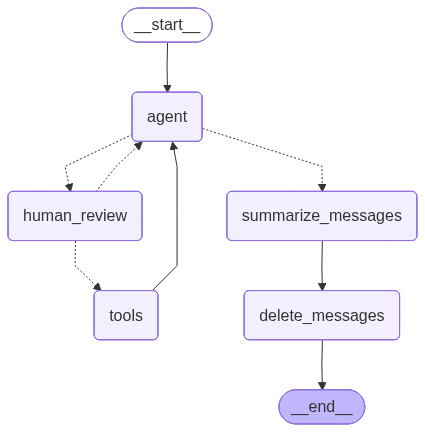

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

query = 'LLM Survey 논문의 내용을 검색해서 요약해주세요'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문의 내용을 검색해서 요약해주세요
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_saEhUz93xagalfZBiUa06KEG)
 Call ID: call_saEhUz93xagalfZBiUa06KEG
  Args:
    query: LLM Survey 논문 내용 요약
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_saEhUz93xagalfZBiUa06KEG)
 Call ID: call_saEhUz93xagalfZBiUa06KEG
  Args:
    query: LLM Survey 논문 내용 요약


In [24]:
for chunk in graph.stream(
    Command(resume={"action": "update_tool", "data": "arxiv말고 web에서 검색해주세요"}),
    config,
    stream_mode="updates",
):
    print(chunk)

{'human_review': {'messages': [{'tool_call_id': 'call_saEhUz93xagalfZBiUa06KEG', 'name': 'duckduckgo_search', 'role': 'tool', 'content': 'arxiv말고 web에서 검색해주세요'}]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 220, 'total_tokens': 241, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3683ee3deb', 'id': 'chatcmpl-CttEezxPbAXRnEJNP9RdOgMJFb4XF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b836b-3323-7ce2-aa02-6b6ff2d27169-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'LLM Survey paper summary'}, 'id': 'call_LFFMSPY9YgCeWNPmLTrsi2Dj', 'type': 'tool_call'}], invalid_

In [25]:
for chunk in graph.stream(
    Command(resume={"action": "continue"}),
    config,
    stream_mode="updates",
):
    print(f'chunk == {chunk}')

chunk == {'human_review': None}
chunk == {'tools': {'messages': [ToolMessage(content='Aug 8, 2025 · In this article, I’m going to share how we built our own bullet-proof LLM -Evals (metrics evaluated using LLMs ) to evaluate a text- summarization task. In summary (no pun intended), it involves asking closed-ended questions to: Identify misalignment in factuality between the original text and summary. 2023-12-03: Replenished five survey papers across three categories. A collection of survey papers and resources related to Large Language Models ( LLMs ). Apr 7, 2025 · Deploying LLMs without human supervision and evaluation can lead to significant errors. This post outlines the fundamentals of LLM evaluation for text summarization in high-stakes applications. Feb 9, 2024 · In this paper , we review some of the most prominent LLMs , including three popular LLM families (GPT, LLaMA, PaLM), and discuss their characteristics, contributions and limitations. We also give an overview of techniqu

In [26]:
graph.get_state(config).values['messages']

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 220, 'total_tokens': 241, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3683ee3deb', 'id': 'chatcmpl-CttEezxPbAXRnEJNP9RdOgMJFb4XF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b836b-3323-7ce2-aa02-6b6ff2d27169-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'LLM Survey paper summary'}, 'id': 'call_LFFMSPY9YgCeWNPmLTrsi2Dj', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 220, 'output_tokens': 21, 'total_tokens': 241, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'r